## Notebook Purpose

Initial experiments with ConvDecoder, based upon the original notebook `ConvDecoder_vs_DIP_vs_DD_multicoil.ipynb`.

In [1]:
import os, sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

from utils.transform import np_to_tt, split_complex_vals, recon_ksp_to_img
from utils.helpers import num_params, load_h5, get_masks
from include.decoder_conv import init_convdecoder
from include.mri_helpers import get_scale_factor, get_masked_measurements, \
                                data_consistency
from include.fit import fit
from utils.evaluate import calc_metrics

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(1)
else:
    dtype = torch.FloatTensor

In [2]:
## UNCOMMENT for half precision and INJECT before fitting network
# net = net.half()
# ksp_masked = ksp_masked.half()
# img_masked = img_masked.half()
# mask = mask.half()
# dtype=torch.cuda.HalfTensor

### Run expmts

In [3]:
file_id_list = ['1000267']#, '1000292', '1000254', '1000178']   
    
img_dc_list, img_est_list, img_gt_list, metrics_dc = [], [], [], []
mse_wrt_ksp_list, mse_wrt_img_list = [], []

NUM_ITER_LIST = [1, 1000]
NUM_ITER = 25
# DC_STEP = True

for idx, file_id in enumerate(file_id_list):  
    
    # load full mri measurements
    f, slice_ksp = load_h5(file_id)
    print('file_id: {}'.format(file_id))

    # load mask, M
    mask, mask2d, mask1d = get_masks(f, slice_ksp)
    
    mask1d_ = torch.from_numpy(np.array(mask1d, dtype=np.uint8)) # for dc step
    
#     for NUM_ITER in NUM_ITER_LIST:
    for DC_STEP in [False, True]:
        
        # initialize net, net input seed, and scale slice_ksp accordingly
        net, net_input, slice_ksp = init_convdecoder(slice_ksp, mask)
        
        # for dc step - must do this after scaling slice_ksp
        ksp_orig = np_to_tt(split_complex_vals(slice_ksp))[None, :].type(dtype) #[1,15,640,368,2]
        
        # apply mask to measurements for fitting model
        ksp_masked, img_masked = get_masked_measurements(slice_ksp, mask)
                
        net, mse_wrt_ksp, mse_wrt_img = fit(
            ksp_masked=ksp_masked, img_masked=img_masked,
            net=net, net_input=net_input, mask2d=mask2d,
            mask1d=mask1d_, ksp_orig=ksp_orig, DC_STEP=DC_STEP,
            img_ls=None, num_iter=NUM_ITER, dtype=dtype)

        img_out = net(net_input.type(dtype))[0] # estimate image \hat{x} = G(\hat{C})

        img_dc, img_est = data_consistency(img_out, slice_ksp, mask1d)
        img_gt = recon_ksp_to_img(slice_ksp) # must do this after slice_ksp is scaled

        # save images, metrics
        img_dc_list.append(img_dc)
        img_est_list.append(img_est)
        img_gt_list.append(img_gt) # could do this once per loop
        mse_wrt_ksp_list.append(mse_wrt_ksp)
        mse_wrt_img_list.append(mse_wrt_img)
#         metrics_dc.append(calc_metrics(img_dc, img_gt))

file_id: 1000267


### findings

- with original, single-line indexing command, i.e. `ksp[:,:,:,mask1d==1,:] = ksp_orig[:,:,:,mask1d==1,:]`, the loss remains constant across iterations
    - works if i do a torch f'n e.g. torch.square()
    - doesn't work if i just set ksp_orig.requires_grad = True

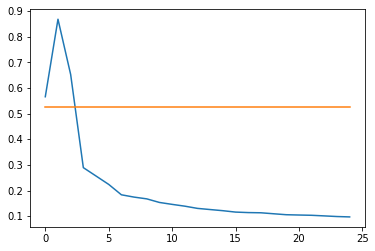

In [4]:
mse_list = mse_wrt_img_list

for idx in range(int(len(mse_list) / 2)):
    plt.plot(mse_list[2*idx])
    plt.plot(mse_list[2*idx+1])
    plt.show()

In [5]:
sys.exit()

SystemExit: 

/home/vanveen/heck/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
for i in np.arange(0, 2*len(file_id_list), 2):
    
    fig = plt.figure(figsize=(16, 8))

    ax1 = fig.add_subplot(141)
    ax1.imshow(img_gt_list[i], cmap='gray')
    ax1.set_title('ground-truth')
    ax1.axis('off')

    ax2 = fig.add_subplot(142)
    ax2.imshow(img_dc_list[i], cmap='gray')
#     ax2.set_title('conv_decoder, iter {}'.format(np.array(NUM_ITER_LIST).min()))
    ax2.set_title('conv_decoder, no dc')
    ax2.axis('off')

    ax3 = fig.add_subplot(143)
    ax3.imshow(img_dc_list[i+1], cmap='gray')
#     ax3.set_title('conv_decoder')
    ax3.set_title('conv_decoder, dc')
    ax3.axis('off')
    
    ax4 = fig.add_subplot(144)
    ax4.imshow(img_est_list[i+1], cmap='gray')
    ax4.set_title('conv_decoder w/o dc post')
    ax4.axis('off')
    
#     plt.savefig('png_out/sample{}.png'.format(i//2))
    plt.show()

In [ ]:
img_gt_shifted = img_gt * (img_dc.mean() / img_gt.mean())

# est is output image without data consistency step
plt.hist(img_est.flatten(), bins=100, alpha=0.5, label='est')
plt.hist(img_dc.flatten(), bins=100, alpha=0.5, label='dc')
plt.hist(img_gt.flatten(), bins=100, alpha=0.5, label='gt')
plt.legend()
plt.show()